In [2]:
!pip install disarray

In [3]:
import tensorflow
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import shutil
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import disarray

In [4]:
def count_jpg_files(root_dir):
    """
    Count all .jpg files in the given directory and its subdirectories
    
    Args:
        root_dir (str): Path to the root directory to start searching from
        
    Returns:
        int: total count
    """
    total_count = 0
    dir_counts = {}
    
    # Walk through all directories
    for dirpath, dirnames, filenames in os.walk(root_dir):
        # Count jpg files in current directory
        jpg_count = len([f for f in filenames if f.lower().endswith('.jpg')])
        total_count += jpg_count
    
    return total_count

In [5]:
train_path = '/kaggle/input/multiclasscovidoasegmentedimages/covidoa_segmented_images/train_directory'
validation_path = '/kaggle/input/multiclasscovidoasegmentedimages/covidoa_segmented_images/validation_directory'
test_path = '/kaggle/input/multiclasscovidoasegmentedimages/covidoa_segmented_images/test_directory'

In [6]:
preprocess_input = tensorflow.keras.applications.resnet50.preprocess_input

image_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [7]:
batch_size = 64
train_image_gen = image_gen.flow_from_directory(train_path, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical')

val_image_gen = image_gen.flow_from_directory(validation_path, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False)

test_image_gen = image_gen.flow_from_directory(test_path, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False)

print(test_image_gen.class_indices)

Found 36927 images belonging to 7 classes.
Found 883 images belonging to 7 classes.
Found 1103 images belonging to 7 classes.
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [8]:
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256,kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
tl_model = Model(inputs=base_model.input, outputs=x)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_value = true_positives / (predicted_positives + K.epsilon())
    return precision_value

def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_value = true_positives / (possible_positives + K.epsilon())
    return recall_value

def f1_score(y_true, y_pred):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    f1_score_value = 2*((precision_value*recall_value)/(precision_value+recall_value+K.epsilon()))
    return f1_score_value

In [10]:
tl_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,114,055 (91.99 MB)

 Trainable params: 24,060,935 (91.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [11]:
optimizer = Adam(0.0001)
tl_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy, precision, recall, f1_score])

In [12]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

lr_reduce = ReduceLROnPlateau(
    monitor='val_categorical_accuracy',
    factor=0.1,
    patience=2,        
    mode='max',
    min_lr=0.00001,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,       
    mode='min',
    restore_best_weights=True,
    verbose=1
)

model_chkpt = ModelCheckpoint(
    "best_model.keras",
    save_best_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    verbose=1
)

callback_list = [model_chkpt, lr_reduce, early_stop]

In [13]:
total_samples = sum([5115, 5950, 5990, 5462, 5510, 4810, 4090])
class_weights = {
    0: total_samples / 5510,
    1: total_samples / 5462,
    2: total_samples / 5990,
    3: total_samples / 4090,
    4: total_samples / 5950,
    5: total_samples / 5115,
    6: total_samples / 4810
}

In [14]:
history = tl_model.fit(train_image_gen,
                       epochs=30, 
                       validation_data = val_image_gen,
                       class_weight = class_weights,
                       callbacks=callback_list)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - categorical_accuracy: 0.5629 - f1_score: 0.5112 - loss: 12.3174 - precision: 0.6965 - recall: 0.4150 - top_2_accuracy: 0.7549 - top_3_accuracy: 0.8577
Epoch 1: val_categorical_accuracy improved from -inf to 0.85617, saving model to best_model.keras
577/577 ━━━━━━━━━━━━━━━━━━━━ 416s 611ms/step - categorical_accuracy: 0.5631 - f1_score: 0.5114 - loss: 12.3143 - precision: 0.6966 - recall: 0.4152 - top_2_accuracy: 0.7550 - top_3_accuracy: 0.8578 - val_categorical_accuracy: 0.8562 - val_f1_score: 0.8266 - val_loss: 4.3823 - val_precision: 0.8742 - val_recall: 0.7943 - val_top_2_accuracy: 0.9422 - val_top_3_accuracy: 0.9762 - learning_rate: 1.0000e-04
Epoch 2/30
577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - categorical_accuracy: 0.7839 - f1_score: 0.7758 - loss: 7.6005 - precision: 0.8407 - recall: 0.7215 - top_2_accuracy: 0.9228 - top_3_accuracy: 0.9738
Epoch 2: val_categorical_accuracy did not improve from 0.85617
577/577 ━━━━━━━━━━━━━━━━━━━━ 16

In [15]:
tl_model.save('val_loss_epoch.keras')

<Axes: >

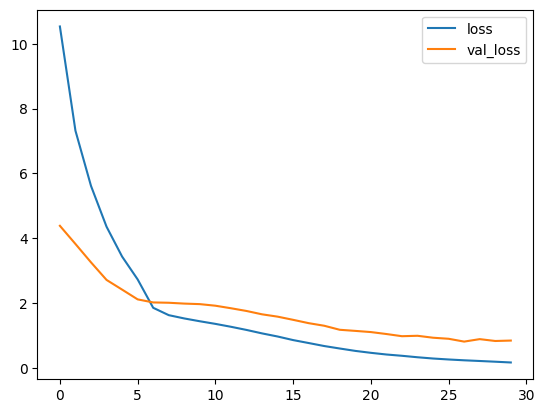

In [16]:
metrics = pd.DataFrame(tl_model.history.history)
metrics[["loss","val_loss"]].plot()

<Axes: >

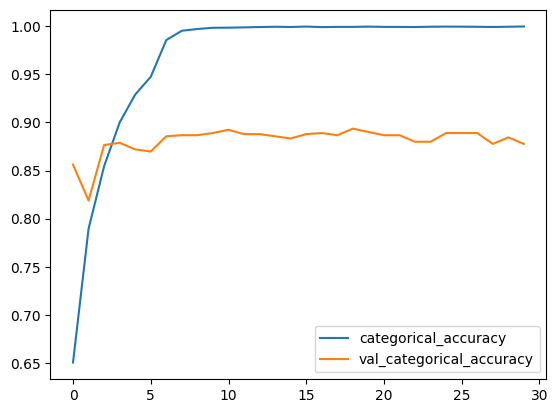

In [17]:
metrics[["categorical_accuracy","val_categorical_accuracy"]].plot()

<Figure size 640x480 with 0 Axes>

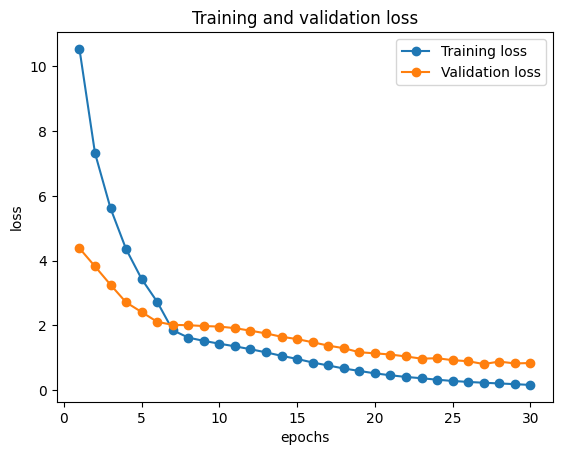

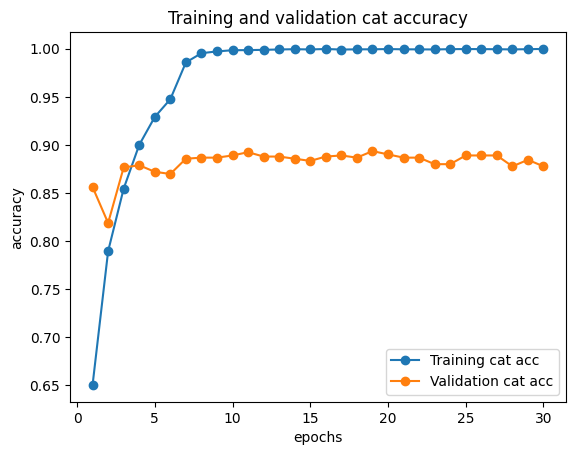

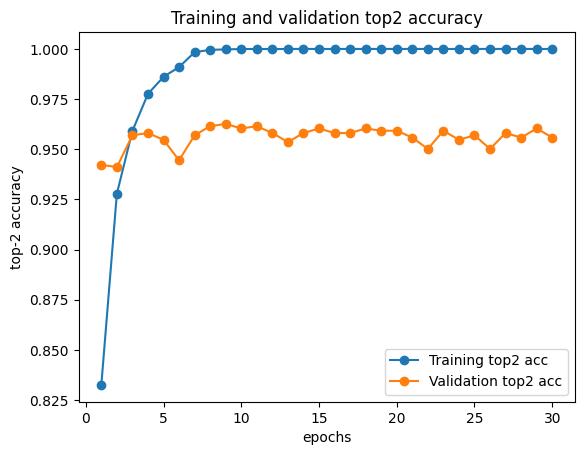

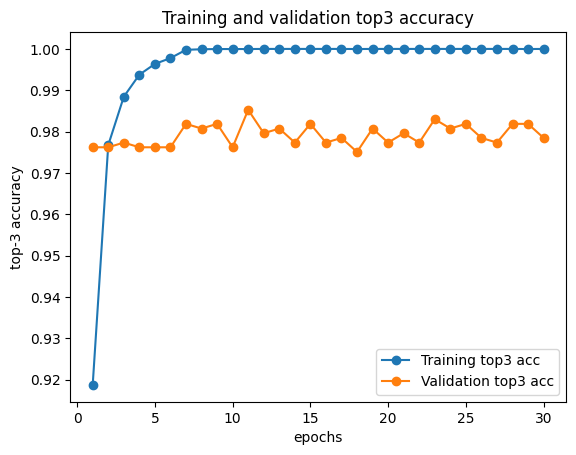

<Figure size 640x480 with 0 Axes>

In [18]:
# display the accuracy, top-2 accuracy and top-3 accuracy

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, "-o", label='Training loss')
plt.plot(epochs, val_loss, "-o", label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
# plt.figure()
plt.savefig('loss.png', dpi=300)
plt.figure()

plt.plot(epochs, acc, "-o", label='Training cat acc')
plt.plot(epochs, val_acc, "-o", label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
# plt.figure()
plt.savefig('acc.png', dpi=300)
plt.figure()

plt.plot(epochs, train_top2_acc, "-o", label='Training top2 acc')
plt.plot(epochs, val_top2_acc, "-o", label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.xlabel('epochs')
plt.ylabel('top-2 accuracy')
plt.legend()
# plt.figure()
plt.savefig('top2acc.png', dpi=300)
plt.figure()

plt.plot(epochs, train_top3_acc, "-o", label='Training top3 acc')
plt.plot(epochs, val_top3_acc, "-o", label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.xlabel('epochs')
plt.ylabel('top-3 accuracy')
plt.legend()
# plt.figure()
plt.savefig('top3acc.png', dpi=300)
plt.figure()

In [19]:
tl_model.load_weights('best_model.keras')
VALIDATION_STEPS = int(np.ceil(count_jpg_files(validation_path) / 64))

In [20]:
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc, val_precision, val_recall, val_f1_score = tl_model.evaluate(val_image_gen, steps=VALIDATION_STEPS)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)
print('val_precision:', val_precision)
print('val_recall:', val_recall)
print('val_f1_score', val_f1_score)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - categorical_accuracy: 0.7957 - f1_score: 0.7971 - loss: 1.8372 - precision: 0.8021 - recall: 0.7923 - top_2_accuracy: 0.9141 - top_3_accuracy: 0.9543
val_loss: 1.1744771003723145
val_cat_acc: 0.8935447335243225
val_top_2_acc: 0.9592298865318298
val_top_3_acc: 0.9807474613189697
val_precision: 0.8976467847824097
val_recall: 0.893119752407074
val_f1_score 0.8953494429588318


In [21]:
TEST_STEPS = int(np.ceil(count_jpg_files(test_path) / 64))

In [22]:
test_loss, test_cat_acc, test_top_2_acc, test_top_3_acc, test_precision, test_recall, test_f1_score = tl_model.evaluate(test_image_gen, steps=TEST_STEPS)

print('test_loss:', test_loss)
print('test_cat_acc:', test_cat_acc)
print('test_top_2_acc:', test_top_2_acc)
print('test_top_3_acc:', test_top_3_acc)
print('test_precision:', test_precision)
print('test_recall:', test_recall)
print('test_f1_score', test_f1_score)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 604ms/step - categorical_accuracy: 0.7904 - f1_score: 0.7920 - loss: 1.7826 - precision: 0.7937 - recall: 0.7903 - top_2_accuracy: 0.9037 - top_3_accuracy: 0.9593
test_loss: 1.2048707008361816
test_cat_acc: 0.8884859681129456
test_top_2_acc: 0.9537624716758728
test_top_3_acc: 0.9800543785095215
test_precision: 0.8890491127967834
test_recall: 0.887557864189148
test_f1_score 0.8882933259010315


In [23]:
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)
test_labels = test_image_gen.classes
cm = confusion_matrix(test_labels, predictions)

18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 327ms/step


Normalized confusion matrix
[[0.46666667 0.2        0.1        0.         0.1        0.13333333
  0.        ]
 [0.11428571 0.74285714 0.08571429 0.         0.         0.05714286
  0.        ]
 [0.04545455 0.03409091 0.57954545 0.01136364 0.17045455 0.15909091
  0.        ]
 [0.         0.25       0.125      0.25       0.         0.375
  0.        ]
 [0.02173913 0.         0.10869565 0.         0.5        0.34782609
  0.02173913]
 [0.0011325  0.00339751 0.01472254 0.0011325  0.01472254 0.96489241
  0.        ]
 [0.         0.         0.         0.         0.         0.07692308
  0.92307692]]


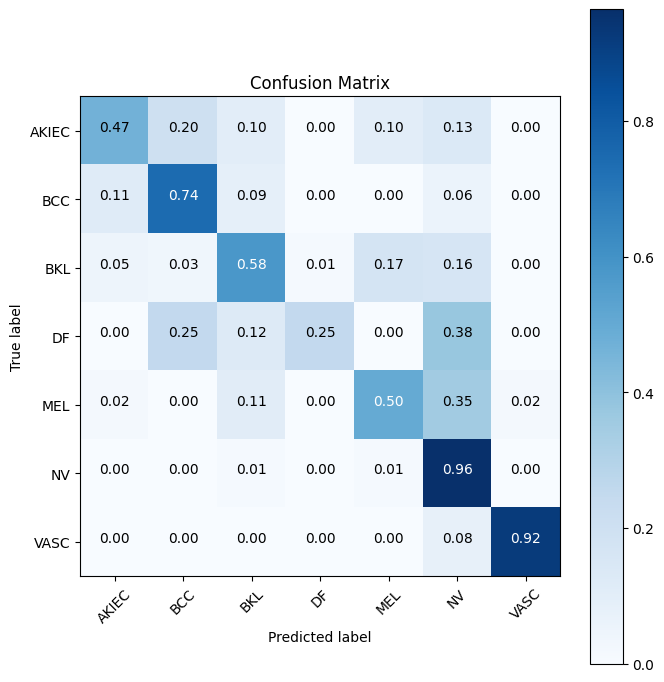

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusionmatrix.png', dpi=300)

    
cm_plot_labels =['AKIEC','BCC','BKL','DF','MEL','NV','VASC']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)

In [25]:
df = pd.DataFrame(cm, index= ['AKIEC','BCC','BKL','DF','MEL','NV','VASC'], columns=['AKIEC','BCC','BKL','DF','MEL','NV','VASC'])
df.da.export_metrics()

,AKIEC,BCC,BKL,DF,MEL,NV,VASC,micro-average
accuracy,0.976428,0.979148,0.943790,0.992747,0.951043,0.935630,0.998187,0.968139
f1,0.518519,0.693333,0.621951,0.333333,0.460000,0.960000,0.923077,0.888486
false_discovery_rate,0.416667,0.350000,0.328947,0.500000,0.574074,0.044843,0.076923,0.111514
false_negative_rate,0.533333,0.257143,0.420455,0.750000,0.500000,0.035108,0.076923,0.111514
false_positive_rate,0.009320,0.013109,0.024631,0.001826,0.029328,0.181818,0.000917,0.018586
negative_predictive_value,0.985171,0.991533,0.963973,0.994540,0.978074,0.853081,0.999083,0.981414
positive_predictive_value,0.583333,0.650000,0.671053,0.500000,0.425926,0.955157,0.923077,0.888486
precision,0.583333,0.650000,0.671053,0.500000,0.425926,0.955157,0.923077,0.888486
recall,0.466667,0.742857,0.579545,0.250000,0.500000,0.964892,0.923077,0.888486
sensitivity,0.466667,0.742857,0.579545,0.250000,0.500000,0.964892,0.923077,0.888486


In [26]:
tl_model.load_weights('val_loss_epoch.keras')
VALIDATION_STEPS = int(np.ceil(count_jpg_files(validation_path) / 64))

In [27]:
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc, val_precision, val_recall, val_f1_score = tl_model.evaluate(val_image_gen, steps=VALIDATION_STEPS)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)
print('val_precision:', val_precision)
print('val_recall:', val_recall)
print('val_f1_score', val_f1_score)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - categorical_accuracy: 0.7767 - f1_score: 0.7740 - loss: 1.4565 - precision: 0.7771 - recall: 0.7709 - top_2_accuracy: 0.9068 - top_3_accuracy: 0.9465
val_loss: 0.809968113899231
val_cat_acc: 0.889014720916748
val_top_2_acc: 0.9580973982810974
val_top_3_acc: 0.9773499369621277
val_precision: 0.8900904059410095
val_recall: 0.8875393867492676
val_f1_score 0.8888004422187805


In [28]:
TEST_STEPS = int(np.ceil(count_jpg_files(test_path) / 64))

In [29]:
test_loss, test_cat_acc, test_top_2_acc, test_top_3_acc, test_precision, test_recall, test_f1_score = tl_model.evaluate(test_image_gen, steps=TEST_STEPS)

print('test_loss:', test_loss)
print('test_cat_acc:', test_cat_acc)
print('test_top_2_acc:', test_top_2_acc)
print('test_top_3_acc:', test_top_3_acc)
print('test_precision:', test_precision)
print('test_recall:', test_recall)
print('test_f1_score', test_f1_score)

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - categorical_accuracy: 0.7761 - f1_score: 0.7765 - loss: 1.3876 - precision: 0.7773 - recall: 0.7757 - top_2_accuracy: 0.9077 - top_3_accuracy: 0.9518
test_loss: 0.8339130282402039
test_cat_acc: 0.8803263902664185
test_top_2_acc: 0.9582955837249756
test_top_3_acc: 0.9809610247612
test_precision: 0.8773643970489502
test_recall: 0.8769097328186035
test_f1_score 0.8771352767944336


In [30]:
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)
test_labels = test_image_gen.classes
cm = confusion_matrix(test_labels, predictions)

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step


Normalized confusion matrix
[[0.4        0.1        0.16666667 0.         0.13333333 0.2
  0.        ]
 [0.08571429 0.62857143 0.17142857 0.         0.         0.11428571
  0.        ]
 [0.01136364 0.02272727 0.57954545 0.01136364 0.15909091 0.21590909
  0.        ]
 [0.         0.25       0.         0.25       0.         0.5
  0.        ]
 [0.         0.02173913 0.08695652 0.         0.56521739 0.32608696
  0.        ]
 [0.0011325  0.00339751 0.01698754 0.         0.01812005 0.9592299
  0.0011325 ]
 [0.         0.         0.         0.         0.         0.15384615
  0.84615385]]


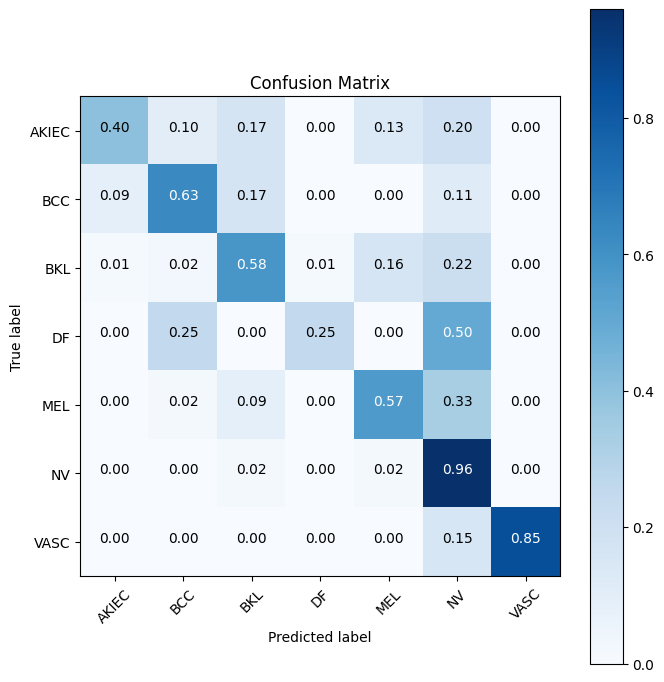

In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusionmatrix_valloss.png', dpi=300)

    
cm_plot_labels =['AKIEC','BCC','BKL','DF','MEL','NV','VASC']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)

In [33]:
df = pd.DataFrame(cm, index= ['AKIEC','BCC','BKL','DF','MEL','NV','VASC'], columns=['AKIEC','BCC','BKL','DF','MEL','NV','VASC'])
df.da.export_metrics()

,AKIEC,BCC,BKL,DF,MEL,NV,VASC,micro-average
accuracy,0.979148,0.978241,0.939257,0.993654,0.951043,0.922031,0.997280,0.965808
f1,0.510638,0.647059,0.603550,0.363636,0.490566,0.951685,0.880000,0.880326
false_discovery_rate,0.294118,0.333333,0.370370,0.333333,0.566667,0.055741,0.083333,0.119674
false_negative_rate,0.600000,0.371429,0.420455,0.750000,0.434783,0.040770,0.153846,0.119674
false_positive_rate,0.004660,0.010300,0.029557,0.000913,0.032167,0.227273,0.000917,0.019946
negative_predictive_value,0.983425,0.987850,0.963796,0.994545,0.980825,0.825243,0.998167,0.980054
positive_predictive_value,0.705882,0.666667,0.629630,0.666667,0.433333,0.944259,0.916667,0.880326
precision,0.705882,0.666667,0.629630,0.666667,0.433333,0.944259,0.916667,0.880326
recall,0.400000,0.628571,0.579545,0.250000,0.565217,0.959230,0.846154,0.880326
sensitivity,0.400000,0.628571,0.579545,0.250000,0.565217,0.959230,0.846154,0.880326
